In [30]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
from typing import Dict, List
import torch.nn as nn
import numpy as np

class ModelInspector:
    def __init__(self, model_name="BAAI/bge-large-en-v1.5"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_attentions=True)
        self.attention_outputs = {}

    def inspect_text(self, text: str, verbose=True):
        # Tokenize and get model outputs
        inputs = self.tokenizer(text, return_tensors='pt', padding=True)

        # Print tokenization details if verbose
        if verbose:
            print("\n=== Tokenization ===")
            tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
            print(f"Tokens: {tokens}")
            print(f"Token IDs: {inputs['input_ids'][0].tolist()}")

        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True, output_attentions=True)

        # Hidden states analysis
        if verbose:
            print("\n=== Hidden States Analysis ===")
            # hidden_states includes the initial embedding layer + output of each layer
            for layer_idx, hidden_state in enumerate(outputs.hidden_states):
                layer_name = "Embedding Layer" if layer_idx == 0 else f"Layer {layer_idx-1} Output"
                print(f"\n{layer_name}")
                print(f"Shape: {hidden_state.shape}")
                # Print stats for the first token's embedding
                first_token_embedding = hidden_state[0][0]
                print(f"First token statistics:")
                print(f"  Mean: {first_token_embedding.mean().item():.4f}")
                print(f"  Std: {first_token_embedding.std().item():.4f}")
                print(f"  First 5 values: {first_token_embedding[:5].tolist()}")

        # Attention analysis
        if verbose:
            print("\n=== Attention Analysis ===")
            for layer_idx, attention_layer in enumerate(outputs.attentions):
                print(f"\nAttention Layer {layer_idx}")
                print(f"Shape: {attention_layer.shape}")
                # Average attention across all heads for the first token
                avg_attention = attention_layer[0, :, 0, :].mean(dim=0)
                print(f"Average attention for first token (first 5 positions):")
                print(avg_attention[:5].tolist())

        return {
            'tokens': self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),
            'token_ids': inputs['input_ids'][0].tolist(),
            'hidden_states': outputs.hidden_states,
            'attentions': outputs.attentions,
            'pooler_output': outputs.pooler_output
        }

    def compare_layer_similarities(self, text: str):
        """Compare cosine similarities between layers for the [CLS] token"""
        outputs = self.inspect_text(text, verbose=False)
        hidden_states = outputs['hidden_states']

        # Extract [CLS] token representations from each layer
        cls_embeddings = torch.stack([states[0, 0] for states in hidden_states])

        # Compute cosine similarity matrix
        similarities = torch.nn.functional.cosine_similarity(
            cls_embeddings.unsqueeze(0),
            cls_embeddings.unsqueeze(1),
            dim=2
        )

        print("\n=== Layer Similarity Analysis ===")
        print("Cosine similarities between layer outputs ([CLS] token):")
        print(f"Shape: {similarities.shape}")
        print("Similarity matrix:")
        # Print with layer labels
        n_layers = len(hidden_states)
        print("\nLayer similarities (rounded to 2 decimal places):")
        for i in range(n_layers):
            layer_name = "Emb" if i == 0 else f"L{i-1}"
            print(f"{layer_name:>4}", end=" ")
        print()
        for i in range(n_layers):
            layer_name = "Emb" if i == 0 else f"L{i-1}"
            print(f"{layer_name:>4}", end=" ")
            for j in range(n_layers):
                print(f"{similarities[i,j].item():>4.2f}", end=" ")
            print()

        return similarities

# Example usage
inspector = ModelInspector()
text = "This is a test sentence to analyze."

# Get detailed layer-by-layer analysis
outputs = inspector.inspect_text(text)

# Compare similarities between layers
# similarities = inspector.compare_layer_similarities(text)


=== Tokenization ===
Tokens: ['[CLS]', 'this', 'is', 'a', 'test', 'sentence', 'to', 'analyze', '.', '[SEP]']
Token IDs: [101, 2023, 2003, 1037, 3231, 6251, 2000, 17908, 1012, 102]

=== Hidden States Analysis ===

Embedding Layer
Shape: torch.Size([1, 10, 1024])
First token statistics:
  Mean: -0.0432
  Std: 0.2672
  First 5 values: [-0.057887326925992966, -0.14541026949882507, -0.11492417752742767, -0.034093450754880905, -0.0692085400223732]

Layer 0 Output
Shape: torch.Size([1, 10, 1024])
First token statistics:
  Mean: 0.0092
  Std: 0.4190
  First 5 values: [-0.022826042026281357, -0.013216034509241581, -0.015569763258099556, 0.01007071603089571, -0.0042159100994467735]

Layer 1 Output
Shape: torch.Size([1, 10, 1024])
First token statistics:
  Mean: 0.0102
  Std: 0.4291
  First 5 values: [0.024927280843257904, -0.021419940516352654, -0.0030374443158507347, 0.05676053464412689, -0.017404068261384964]

Layer 2 Output
Shape: torch.Size([1, 10, 1024])
First token statistics:
  Mean: 0.0


Tracking embedding changes for token: '[CLS]'
Number of layers: 25
Embedding dimension: 1024

Embedding Statistics:
Initial layer mean: -0.0432
Final layer mean: -0.0040
Initial layer std: 0.2671
Final layer std: 0.5257


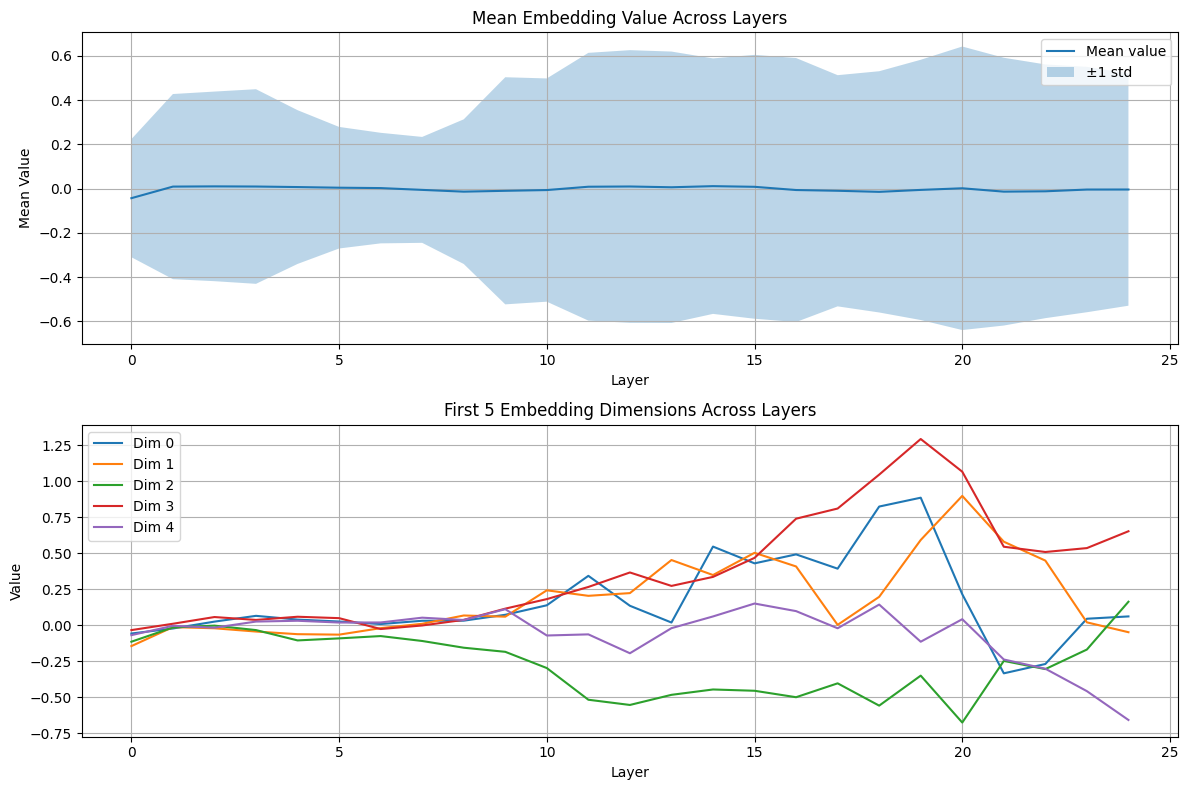

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

class EmbeddingVisualizer:
    def __init__(self, model_name="BAAI/bge-large-en-v1.5"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def track_token_embedding(self, text: str, token_position: int = 0):
        # Tokenize input
        inputs = self.tokenizer(text, return_tensors='pt', padding=True)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        # Get embeddings from all layers
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)

        # Collect the specified token's embedding from each layer
        token_embeddings = []

        for layer_idx, layer_output in enumerate(outputs.hidden_states):
            # Extract the embedding for the specified token
            # Shape of layer_output is [1, sequence_length, 1024]
            # We take [0] to remove batch dimension, [token_position] to get specific token
            token_embedding = layer_output[0, token_position].numpy()
            token_embeddings.append(token_embedding)

        token_embeddings = np.array(token_embeddings)

        print(f"\nTracking embedding changes for token: '{tokens[token_position]}'")
        print(f"Number of layers: {len(token_embeddings)}")
        print(f"Embedding dimension: {token_embeddings.shape[1]}")

        # Calculate statistics
        means = np.mean(token_embeddings, axis=1)
        stds = np.std(token_embeddings, axis=1)

        # Plot embedding changes
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Plot mean values across layers
        ax1.plot(means, label='Mean value')
        ax1.fill_between(range(len(means)), means - stds, means + stds, alpha=0.3, label='±1 std')
        ax1.set_title('Mean Embedding Value Across Layers')
        ax1.set_xlabel('Layer')
        ax1.set_ylabel('Mean Value')
        ax1.legend()
        ax1.grid(True)

        # Plot first 5 dimensions across layers
        for i in range(5):
            ax2.plot(token_embeddings[:, i], label=f'Dim {i}')
        ax2.set_title('First 5 Embedding Dimensions Across Layers')
        ax2.set_xlabel('Layer')
        ax2.set_ylabel('Value')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        return {
            'embeddings': token_embeddings,
            'means': means,
            'stds': stds,
            'token': tokens[token_position]
        }

    def track_sentence_embeddings(self, text):
        inputs = self.tokenizer(text, return_tensors='pt')

        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)

        layer_embeddings = []
        for layer_output in outputs.hidden_states:
            # Layer norm
            normalized = self.model.encoder.layer[0].attention.output.LayerNorm(layer_output)
            # Mean pool
            sentence_embedding = torch.mean(normalized, dim=1)  # [1, 1024]
            # L2 normalize
            sentence_embedding = torch.nn.functional.normalize(sentence_embedding, p=2, dim=1)
            layer_embeddings.append(sentence_embedding)

        return layer_embeddings

# Example usage
visualizer = EmbeddingVisualizer()
text = "This is a test sentence to analyze."
results = visualizer.track_token_embedding(text, token_position=0)  # Track first token

# Print some statistics
print("\nEmbedding Statistics:")
print(f"Initial layer mean: {results['means'][0]:.4f}")
print(f"Final layer mean: {results['means'][-1]:.4f}")
print(f"Initial layer std: {results['stds'][0]:.4f}")
print(f"Final layer std: {results['stds'][-1]:.4f}")

In [12]:
visualizer = EmbeddingVisualizer()
text = "This is a test sentence to analyze."

embeddings = visualizer.track_sentence_embeddings(text)

In [18]:
import torch
import numpy as np
embeddings = [layer.detach().numpy() for layer in embeddings]

In [19]:
import numpy as np
import torch
from sklearn.decomposition import PCA

def perform_pca(embeddings_list, n_components=2):
    # Concatenate embeddings into a single array
    all_embeddings = np.concatenate(embeddings_list, axis=0)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(all_embeddings)

    return reduced_embeddings

reduced_embeddings = perform_pca(embeddings)
reduced_embeddings

array([[-0.27161354,  0.5924032 ],
       [-0.29619497,  0.6646117 ],
       [-0.29921356,  0.6711067 ],
       [-0.29896128,  0.6805168 ],
       [-0.3015821 ,  0.6743616 ],
       [-0.31667215,  0.64807177],
       [-0.35852098,  0.3872786 ],
       [-0.39190397, -0.37518373],
       [-0.42656967, -0.48815632],
       [-0.43716794, -0.5147092 ],
       [-0.432422  , -0.52485245],
       [-0.43035528, -0.5002976 ],
       [-0.41382486, -0.50413966],
       [-0.36478645, -0.4941685 ],
       [-0.22969171, -0.4461703 ],
       [ 0.2814404 , -0.11444604],
       [ 0.38923967, -0.10890551],
       [ 0.43161726, -0.12620288],
       [ 0.49381667, -0.12445542],
       [ 0.6153368 , -0.08698215],
       [ 0.67892444, -0.04026183],
       [ 0.66565603,  0.00673296],
       [ 0.64968526,  0.01060791],
       [ 0.6251861 ,  0.03157479],
       [ 0.4385776 ,  0.08166501]], dtype=float32)

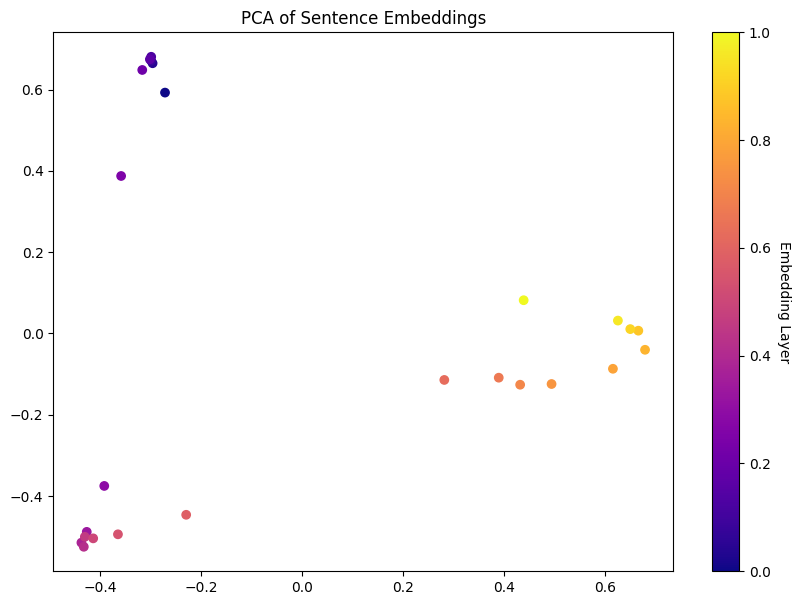

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_embeddings(embeddings, title="PCA of Sentence Embeddings"):
    plt.figure(figsize=(10, 7))  # Made figure slightly larger to accommodate colorbar

    # Create array of indices normalized between 0 and 1
    indices = np.linspace(0, 1, len(embeddings))

    # Use 'plasma' colormap for better visibility - transitions through purple, orange, yellow
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                        c=indices,
                        cmap='plasma')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Embedding Layer', rotation=270, labelpad=15)

    plt.title(title)
    plt.show()

plot_embeddings(reduced_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


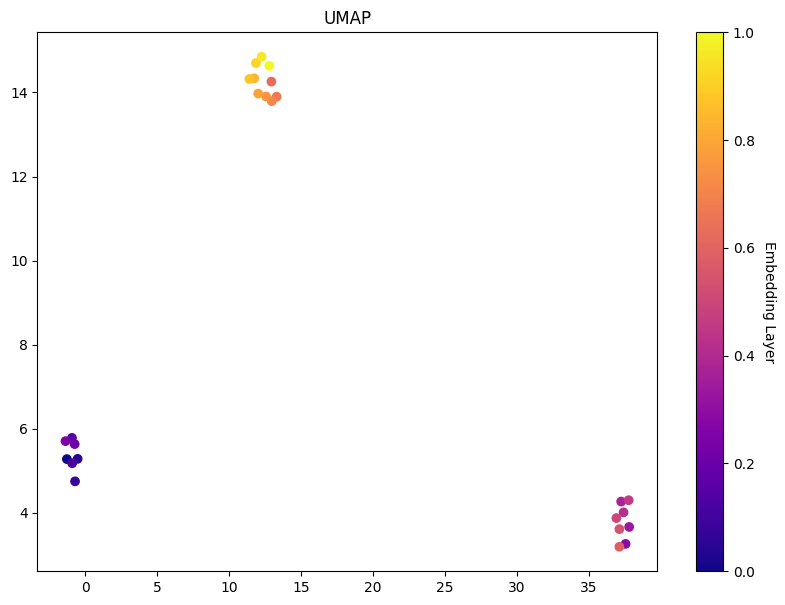

In [35]:
import umap

reducer = umap.UMAP()
embedding_2d = reducer.fit_transform(reduced_embeddings)

plot_embeddings(embedding_2d, title='UMAP')